# Setting up Cassandra

### Installing Cassandra Drivers


In [ ]:
!pip install cassandra-driver


### Importing Libraries

In [ ]:
from cassandra.cluster import Cluster
from cassandra.auth import PlainTextAuthProvider
import json
import pandas as pd
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
import regex
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

### Setting up a connection

In [ ]:
def get_connection():
  try:

    cloud_config= {
      'secure_connect_bundle': 'secure-connect-mydb.zip'
    }
    #Initialize the token downloaded
    with open("mydb-token.json") as f:
        secrets = json.load(f)

    CLIENT_ID = secrets["clientId"]
    CLIENT_SECRET = secrets["secret"]

    auth_provider = PlainTextAuthProvider(CLIENT_ID, CLIENT_SECRET)
    cluster = Cluster(cloud=cloud_config, auth_provider=auth_provider)
    session = cluster.connect()
    if session:
      print("Connection Established !!")
    else:
      print("Connection Failed !!")
    return session

  except Exception as e:
    print(e)
    return None

### Session Creation

In [ ]:
session = get_connection()

Connection Established !!


# Drop Tables If Exists

In [ ]:
session.execute("drop table if exists bigdata.disease_bronze")
session.execute("drop table if exists bigdata.disease_silver")
session.execute("drop table if exists bigdata.gold_df1")
session.execute("drop table if exists bigdata.gold_df2")
session.execute("drop table if exists bigdata.gold_df3")

#Bronze


In [ ]:
def bronze_data():
  try:
    data = pd.read_csv('dd.csv')
    return data
  except Exception as e:
    print(e)
    return None

### Bronze table creation

In [ ]:
def create_bronze_table(session):
    try:
        session.execute(f"""
        CREATE TABLE IF NOT EXISTS bigdata.disease_bronze (
            surrogate_key INT PRIMARY KEY,
            disease TEXT,
            county TEXT,
            year INT,
            sex TEXT,
            cases FLOAT,
            population INT,
            rate TEXT,
            lower_95_ci FLOAT,
            upper_95_ci FLOAT
        );
        """)
        print(f"Table bigdata.disease_bronze created successfully.")
    except Exception as e:
        print(f"Error creating table data.disease_bronze: {e}")

### Insert into Bronze Table

In [ ]:
def insert_data_to_bronze(session, data):
    prepared_stmt = session.prepare(f"""
    INSERT INTO bigdata.disease_bronze (surrogate_key, disease, county, year, sex, cases, population, rate, lower_95_ci, upper_95_ci)
    VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?);
    """)
    try:
        for index, row in data.iterrows():
            session.execute(prepared_stmt, (
                int(row['Surrogate Key']), row['Disease'], row['County'], int(row['Year']),
                row['Sex'], float(row['Cases']) if pd.notna(row['Cases']) else None,
                int(row['Population']), row['Rate'],
                float(row['Lower_95__CI']) if pd.notna(row['Lower_95__CI']) else None,
                float(row['Upper_95__CI']) if pd.notna(row['Upper_95__CI']) else None))
        print(f"Data inserted successfully into data.disease_bronze.")
    except Exception as e:
        print(f"Error inserting data into bigdata.disease_bronze: {e}")

## Data Cleaning

### Drop Missing Values

In [ ]:
def drop_missing_values(data):
    """
    Drops rows with any missing values in the DataFrame.

    Parameters:
        data (DataFrame): The pandas DataFrame from which to drop rows with missing values.

    Returns:
        DataFrame: A DataFrame with rows containing missing values removed.
    """
    try:
        cleaned_data = data.dropna()
        print("Missing values dropped.")
        return cleaned_data
    except Exception as e:
        print(f"Failed to drop missing values: {e}")
        return data

### Fill Missing Values

In [ ]:
def fill_missing_values(data, column, method='mean'):
    """
    Fills missing values in a specified column of the dataframe with a given value.

    Parameters:
        data (DataFrame): The pandas DataFrame to process.
        column (str): The column in which to fill missing values.
        method : The value to fill missing values with. Default is mean.
    """
    try:
        if method == 'mean':
            fill_value = data[column].mean()
        elif method == 'median':
            fill_value = data[column].median()
        data[column] = data[column].fillna(fill_value)
        print(f"Missing values filled using {method}.")
        return data

    except Exception as e:
        print(f"Error filling missing values in {column}: {e}")

### Convert Data Types

In [ ]:
def convert_data_type(data, column, dtype):
    """
    Converts the data type of a specified column in the dataframe.

    Parameters:
        data (DataFrame): The pandas DataFrame to process.
        column (str): The column for which to change the data type.
        dtype (type): The new data type (e.g., int, float, str).
    """
    if data is None or data.empty:
        print("DataFrame is empty or not defined.")
        return data

    try:
        data[column] = data[column].astype(dtype)
        print(f"Converted {column} to {dtype}.")
    except Exception as e:
        print(f"Error converting data type of {column}: {e}")
    return data

### Remove invalid Data

In [ ]:
def remove_invalid_data(data, column, condition):
    """
    Removes rows from the DataFrame that contain a specified invalid condition in a specific column.

    Parameters:
        data (DataFrame): The pandas DataFrame to process.
        column (str): The column to inspect for the invalid condition.
        condition: The condition that identifies a row as invalid.

    Returns:
        DataFrame: A DataFrame with invalid rows removed based on the condition.
    """
    try:
        cleaned_data = data[data[column] != condition]
        print(f"Invalid data removed from {column}.")
        return cleaned_data
    except Exception as e:
        print(f"Failed to remove invalid data from {column}: {e}")
        return data

### Replace Values

In [ ]:
def replace_values(data, column, old_value, new_value):
    """
    Replaces specified old values with new values in a particular column of the DataFrame.

    Parameters:
        data (DataFrame): The pandas DataFrame to process.
        column (str): The column where values need to be replaced.
        old_value: The value to be replaced.
        new_value: The value to replace with.

    Returns:
        DataFrame: A DataFrame with specified values replaced.
    """
    try:
        data[column] = data[column].replace(old_value, new_value)
        print(f"Replaced {old_value} with {new_value} in {column}.")
        return data
    except Exception as e:
        print(f"Failed to replace values in {column}: {e}")
        return data

### Normalize Columns

In [ ]:
def normalize_column(data, column):
    """
    Normalizes the values in a specified column of the DataFrame using Min-Max scaling.

    Parameters:
        data (DataFrame): The pandas DataFrame to process.
        column (str): The column whose values are to be normalized.

    Returns:
        DataFrame: A DataFrame with the specified column normalized.
    """
    try:
        scaler = MinMaxScaler()
        data[column] = scaler.fit_transform(data[[column]])
        print(f"Normalized {column}.")
        return data
    except Exception as e:
        print(f"Failed to normalize {column}: {e}")
        return data

### Replace erroneous values

In [ ]:
def replace_erroneous_values(data, column, to_replace, new_value):
    """
    Replaces erroneous values in a specified column of the dataframe.

    Parameters:
        data (DataFrame): The pandas DataFrame to process.
        column (str): The column where values need to be replaced.
        to_replace: The value to be replaced.
        new_value: The new value to replace with.
    """
    try:
        data[column].replace(to_replace, new_value)
        print(f"Replaced {to_replace} with {new_value} in {column}.")
        return data
    except Exception as e:
        print(f"Error replacing values in {column}: {e}")

### Rename new column names

In [ ]:
def rename_columns(data, new_names):
    """
    Renames columns in the dataframe according to a given mapping.

    Parameters:
        data (DataFrame): The pandas DataFrame to process.
        new_names (dict): A dictionary mapping old column names to new names.
    """
    try:
        data.rename(columns=new_names)
        print("Columns renamed successfully.")

    except Exception as e:
        print(f"Error renaming columns: {e}")

### Remove Duplicates

In [ ]:
def remove_duplicates(data):
    """
    Removes duplicate rows from the dataframe.

    Parameters:
        data (DataFrame): The pandas DataFrame to process.
    """
    try:
        data=data.drop_duplicates()
        print("Duplicate rows removed.")
        return data
    except Exception as e:
        print("Error removing duplicate rows: {e}")

In [ ]:
def clean_asterisk(data, column):
    """
    Removes asterisks (*) from the end of the string values in a specified column of the DataFrame.

    Parameters:
        data (DataFrame): The pandas DataFrame to process.
        column (str): The column in which values are to be cleaned.

    Returns:
        DataFrame: A DataFrame with asterisks removed from the end of values in the specified column.
    """
    if data is None or data.empty:
        print("DataFrame is empty or not defined. asterisk")
        return data  # Return the unchanged DataFrame or None if it's None.

    try:
        data[column] = data[column].str.replace(r'\*$', '', regex=True)
        print(f"Asterisks removed from {column}.")
    except Exception as e:
        print(f"Failed to remove asterisks from {column}: {e}")
    return data

## Bronze Operations

In [ ]:
def bronze_clean(data):

  try:
      """
      Processes the 'bronze' DataFrame through various cleaning steps to produce a 'silver' DataFrame.
      Each step includes error handling to ensure robust data cleaning operations.

      Parameters:
          data (DataFrame): The initial 'bronze' DataFrame to be cleaned and processed.

      Returns:
          DataFrame: The cleaned and processed 'silver' DataFrame.
      """

      # Rename columns for clarity
      rename_columns(data, {'Lower_95__CI': 'Lower_95_CI', 'Upper_95__CI': 'Upper_95_CI'})

      # Convert 'Rate' from string to numeric, replacing erroneous '-' values
      data=replace_erroneous_values(data, 'Rate', '-', None)

      ## Clean rate column having asterisk
      data = clean_asterisk(data, 'Rate')


      # Fill missing values for specific columns, if no rows were dropped
      if not data.empty:
          data=fill_missing_values(data, 'Population', 'median')
          data=fill_missing_values(data, 'Cases', 'mean')
          data=fill_missing_values(data, 'Upper_95__CI', 'mean')
          data=fill_missing_values(data, 'Lower_95__CI', 'mean')


      # data type conversion of year
      data=convert_data_type(data, 'Year', int)

      # Remove invalid data from a specific column
      data = remove_invalid_data(data, 'County', 'Invalid_County')

      # Replace specific old values with new ones in a column
      replace_values(data, 'Sex', 'Unknown', 'Other')

      # Remove duplicate rows
      remove_duplicates(data)

      return data

  except Exception as e:
      print(f"Error in bronze_operations: {e}")
      return None

## Silver Table

In [ ]:
def create_silver_table(session):
    try:
        session.execute(f"""
        CREATE TABLE IF NOT EXISTS bigdata.disease_silver (
            surrogate_key INT PRIMARY KEY,
            disease TEXT,
            county TEXT,
            year INT,
            sex TEXT,
            cases FLOAT,
            population INT,
            rate TEXT,
            lower_95_ci FLOAT,
            upper_95_ci FLOAT
        );
        """)
        print(f"Table bigdata.disease_silver created successfully.")
    except Exception as e:
        print(f"Error creating table bigdata.disease_silver: {e}")

## Silver table insert

In [ ]:
def insert_data_to_silver(session, silver_df):
    prepared_stmt = session.prepare(f"""
    INSERT INTO bigdata.disease_silver (surrogate_key, disease, county, year, sex, cases, population, rate, lower_95_ci, upper_95_ci)
    VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?);
    """)
    try:
        for index, row in silver_df.iterrows():
            session.execute(prepared_stmt, (
                int(row['Surrogate Key']), row['Disease'], row['County'], int(row['Year']),
                row['Sex'], float(row['Cases']) if pd.notna(row['Cases']) else None,
                int(row['Population']), row['Rate'],
                float(row['Lower_95__CI']) if pd.notna(row['Lower_95__CI']) else None,
                float(row['Upper_95__CI']) if pd.notna(row['Upper_95__CI']) else None))
        print(f"Data inserted successfully into bigdata.disease_silver.")
    except Exception as e:
        print(f"Error inserting data into bigdata.disease_silver: {e}")

# Gold

### Create Gold DF1

In [ ]:
def create_gold_df1(silver_df):
    """
    Aggregates the total and average cases per year from the silver dataset.

    Parameters:
        silver_df (DataFrame): Cleaned DataFrame with at least 'Year' and 'Cases' columns.

    Returns:
        DataFrame: Aggregated DataFrame with each year's total and average cases.
    """
    gold_df1 = silver_df.groupby('Year').agg(
        Total_Cases=pd.NamedAgg(column='Cases', aggfunc='sum'),
        Average_Cases=pd.NamedAgg(column='Cases', aggfunc='mean')
    ).reset_index()
    return gold_df1

### Create Gold DF1 Table

In [ ]:
def create_table_gold_df1(session):
    """
    Creates a table for storing total and average cases per year in Cassandra.

    Parameters:
        session: The Cassandra session object.
    """
    session.execute("""
    CREATE TABLE IF NOT EXISTS bigdata.gold_df1 (
        year INT PRIMARY KEY,
        total_cases INT,
        average_cases FLOAT
    )
    """)

### Insert into Gold DF1 Table

In [ ]:
def insert_data_gold_df1(session, data):
    """
    Inserts data into the bigdata.gold_df1 table.

    Parameters:
        session: The Cassandra session object.
        data (DataFrame): DataFrame containing 'Year', 'Total_Cases', and 'Average_Cases'.
    """
    for index, row in data.iterrows():
        session.execute("""
        INSERT INTO bigdata.gold_df1 (year, total_cases, average_cases)
        VALUES (%s, %s, %s)
        """, (int(row['Year']), int(row['Total_Cases']), float(row['Average_Cases'])))

### Plot cases by year

In [ ]:
def plot_cases_by_year(gold_df1):
    """
    Creates a dual-axis plot for total and average cases per year.

    Parameters:
        gold_df1 (DataFrame): DataFrame containing 'Year', 'Total_Cases', and 'Average_Cases'.
    """
    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Plot Total Cases
    color = 'tab:red'
    ax1.set_xlabel('Year')
    ax1.set_ylabel('Total Cases', color=color)
    ax1.plot(gold_df1['Year'], gold_df1['Total_Cases'], color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    # Create a twin axis to plot Average Cases
    ax2 = ax1.twinx()
    color = 'tab:blue'
    ax2.set_ylabel('Average Cases', color=color)
    ax2.plot(gold_df1['Year'], gold_df1['Average_Cases'], color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    plt.title('Total and Average Cases by Year')
    plt.show()

### Create Gold DF2

In [ ]:
def create_gold_df2(silver_df):
    """
    Calculates the average population per year from the silver dataset.

    Parameters:
        silver_df (DataFrame): Cleaned DataFrame with at least 'Year' and 'Population' columns.

    Returns:
        DataFrame: Aggregated DataFrame with each year's average population.
    """
    gold_df2 = silver_df.groupby('Year').agg(
        Average_Population=pd.NamedAgg(column='Population', aggfunc='mean')
    ).reset_index()
    return gold_df2

### Create Gold DF2 Table

In [ ]:
def create_table_gold_df2(session):
    """
    Creates a table for storing average population per year in Cassandra.

    Parameters:
        session: The Cassandra session object.
    """
    session.execute("""
    CREATE TABLE IF NOT EXISTS bigdata.gold_df2 (
        year INT PRIMARY KEY,
        average_population FLOAT
    )
    """)

### Insert into Gold DF2 Table

In [ ]:
def insert_data_gold_df2(session, data):
    """
    Inserts data into the bigdata.gold_df2 table.

    Parameters:
        session: The Cassandra session object.
        data (DataFrame): DataFrame containing 'Year' and 'Average_Population'.
    """
    for index, row in data.iterrows():
        session.execute("""
        INSERT INTO bigdata.gold_df2 (year, average_population)
        VALUES (%s, %s)
        """, (int(row['Year']), float(row['Average_Population'])))

### Plot average population

In [ ]:
def plot_average_population(gold_df2):
    """
    Creates a bar chart of the average population per year.

    Parameters:
        gold_df2 (DataFrame): DataFrame containing 'Year' and 'Average_Population'.
    """
    plt.figure(figsize=(10, 6))
    plt.bar(gold_df2['Year'], gold_df2['Average_Population'], color='skyblue')
    plt.xlabel('Year')
    plt.ylabel('Average Population')
    plt.title('Average Population by Year')
    plt.grid(True)
    plt.show()

### Create Gold DF3

In [ ]:
def create_gold_df3(silver_df):
    """
    Counts the number of entries per year and gender from the silver dataset.

    Parameters:
        silver_df (DataFrame): Cleaned DataFrame with at least 'Year' and 'Sex' columns.

    Returns:
        DataFrame: Aggregated DataFrame with each year's and gender's count of entries.
    """
    gold_df3 = silver_df.groupby(['Year', 'Sex']).size().reset_index(name='Count')
    return gold_df3

### Create Gold DF3 Table

In [ ]:
def create_table_gold_df3(session):
    """
    Creates a table for storing counts of entries by year and gender in Cassandra.

    Parameters:
        session: The Cassandra session object.
    """
    session.execute("""
    CREATE TABLE IF NOT EXISTS bigdata.gold_df3 (
        year INT,
        sex TEXT,
        count INT,
        PRIMARY KEY (year, sex)
    )
    """)

### Insert into Gold DF3 Table

In [ ]:
def insert_data_gold_df3(session, data):
    """
    Inserts data into the bigdata.gold_df3 table.

    Parameters:
        session: The Cassandra session object.
        data (DataFrame): DataFrame containing 'Year', 'Sex', and 'Count'.
    """
    for index, row in data.iterrows():
        session.execute("""
        INSERT INTO bigdata.gold_df3 (year, sex, count)
        VALUES (%s, %s, %s)
        """, (int(row['Year']), row['Sex'], int(row['Count'])))

### Predict Gender Distribution

In [ ]:

def predict_gender_distribution(gold_df3):
    """
    Fits a logistic regression model to predict gender based on the year and count of entries.

    Parameters:
        gold_df3 (DataFrame): DataFrame containing 'Year', 'Sex', and 'Count'.

    Returns:
        float: The accuracy of the model.
    """
    # Convert 'Sex' to a binary variable
    gold_df3['Is_Male'] = (gold_df3['Sex'] == 'Male').astype(int)

    X = gold_df3[['Year', 'Count']]
    y = gold_df3['Is_Male']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    model = LogisticRegression()
    model.fit(X_train, y_train)

    predictions = model.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)

    return accuracy

In [ ]:
def table_view(session,table_name):
    """
    Creates a table for storing counts of entries by year and gender in Cassandra.

    Parameters:
        session: The Cassandra session object.
    """
    result =session.execute(f"""
    SELECT * FROM bigdata.{table_name} limit 5;
    """)
    for row in result:
        print(row)  # Print each row of the result

# Main

Bronze Table

Bronze Table created Successfully

Bronze Table inserted Successfully

Row(surrogate_key=4317, cases=0.0, county='Colusa', disease='Anthrax', lower_95_ci=0.0, population=21270, rate='-', sex='Total', upper_95_ci=17.341999053955078, year=2009)
Row(surrogate_key=62693, cases=0.0, county='Orange', disease='Domoic Acid Poisoning', lower_95_ci=0.0, population=1433646, rate='-', sex='Male', upper_95_ci=0.25699999928474426, year=2001)
Row(surrogate_key=121478, cases=0.0, county='Santa Clara', disease='Psittacosis', lower_95_ci=0.0, population=985443, rate='-', sex='Male', upper_95_ci=0.37400001287460327, year=2017)
Row(surrogate_key=113295, cases=0.0, county='San Diego', disease='Paratyphoid Fever', lower_95_ci=0.0, population=3276113, rate='-', sex='Total', upper_95_ci=0.11299999803304672, year=2017)
Row(surrogate_key=176996, cases=0.0, county='Yuba', disease='Vibrio Infection (non-Cholera)', lower_95_ci=0.0, population=39302, rate='-', sex='Male', upper_95_ci=9.38599967956543,

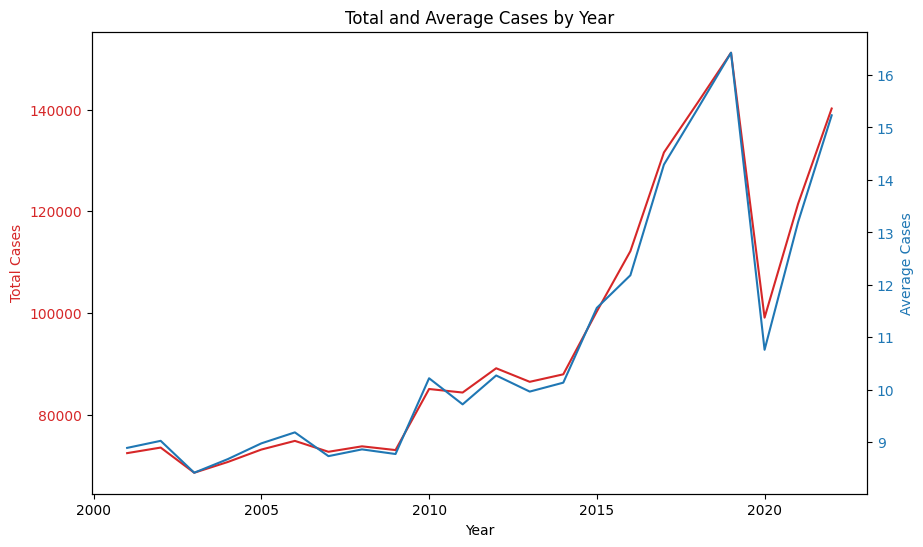

Plot Average Population



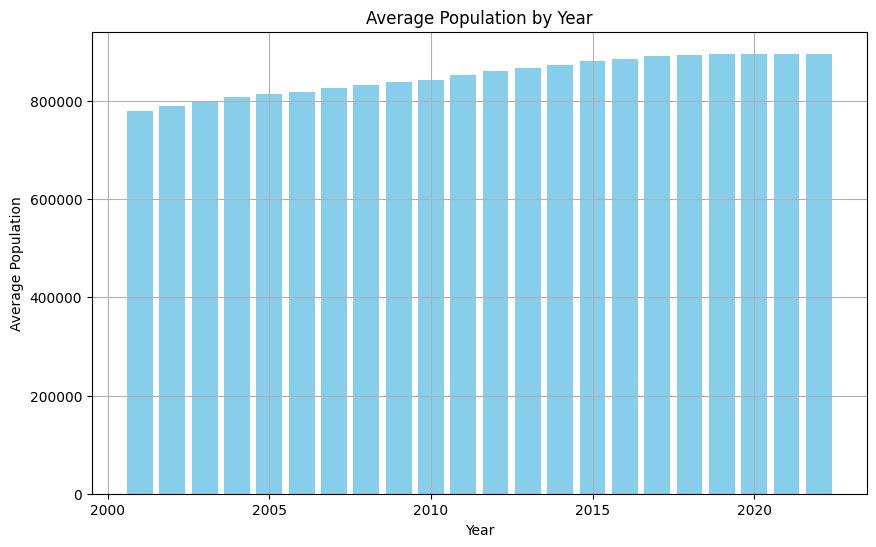

Predict Gender Distribution

The accuracy of the gender prediction model is
: 75.00%


In [ ]:
if __name__ == "__main__":
  try:
    data = bronze_data()
    print("===============================================================================================================================================================")
    print("Bronze Table\n")
    bronze = create_bronze_table(session)
    bronze = insert_data_to_bronze(session,data)
    print("Bronze Table created Successfully\n")
    print("Bronze Table inserted Successfully\n")
    table_view(session,'disease_bronze')


    print("===============================================================================================================================================================")
    print("Silver Table")

    silver_df = bronze_clean(data)

    silver = create_silver_table(session)
    silver = insert_data_to_silver(session,silver_df)
    print("Silver Table created Successfully\n")
    print("Silver Table inserted Successfully\n")
    table_view(session,'disease_silver')

    print("===============================================================================================================================================================")
    print("Gold Tables\n")

    #Gold df1
    gold_df1 = create_gold_df1(silver_df)

    gold1=create_table_gold_df1(session)
    print("Gold table 1 created\n")

    gold1=insert_data_gold_df1(session, gold_df1)
    print("Gold table 1 inserted\n")
    table_view(session,'gold_df1')


    gold_df2 = create_gold_df2(silver_df)

    gold2=create_table_gold_df2(session)
    print("Gold 2 table created\n")

    gold2=insert_data_gold_df2(session, gold_df2)
    print("Gold 2 table inserted\n")
    table_view(session,'gold_df2')


    gold_df3 = create_gold_df3(silver_df)

    gold3=create_table_gold_df3(session)
    print("Gold 3 table created\n")

    gold3=insert_data_gold_df3(session, gold_df3)
    print("Gold 3 table inserted\n")
    table_view(session,'gold_df3')


    print("Visualizations\n")
    print("===============================================================================================================================================================")
    print("Plot Cases by Year\n")
    plot_cases_by_year(gold_df1)
    print("===============================================================================================================================================================")
    print("Plot Average Population\n")
    plot_average_population(gold_df2)
    print("===============================================================================================================================================================")
    print("Predict Gender Distribution\n")
    accuracy = predict_gender_distribution(gold_df3)
    print("===============================================================================================================================================================")
    print(f"The accuracy of the gender prediction model is\n: {accuracy:.2%}")

  except Exception as e:
    print(f"Error in main: {e}")